In [52]:
import json

DATASET_TO_DISPLAY_NAME = {
    "mmlu_clinical": "MMLU-Clinical",
    "truthful_qa": "TruthfulQA",
}
LLM_TO_DISPLAY_NAME = {
    "mistral_7b_instruct": "Mistral-7B-Instruct",
    "phi3_medium_instruct": "Phi3-Medium-Instruct",
    "llama3_8b_instruct": "LLaMA3-8B-Instruct",
}

dataset = "mmlu_clinical"
llm = "llama3_8b_instruct"
conf_measure = "token_prob"

results_file = f"/home/tejas/projects/FAFO/experiments/llm_task_performance/dataset-{dataset}/{llm}-{conf_measure}_conf.json"
results = json.load(open(results_file))


In [53]:
import numpy as np
num_bins = 10

bin_boundaries = np.linspace(0, 1, num_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
ece = 0.0
confidences = np.array([x['prediction_conf'] for x in results])
accuracies = np.array([x['correct'] for x in results])

bin_confs, bin_accs = [], []
for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
    prob_in_bin = in_bin.mean()

    if prob_in_bin.item() > 0:
        # get the accuracy of bin m: acc(Bm)
        accuracy_in_bin = accuracies[in_bin].mean()
        # get the average confidence of bin m: conf(Bm)
        avg_confidence_in_bin = confidences[in_bin].mean()
        # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
        bin_confs.append(avg_confidence_in_bin)
        bin_accs.append(accuracy_in_bin)
brier_score = np.mean(np.square(confidences - accuracies))

confs_when_correct = confidences[accuracies]
confs_when_incorrect = confidences[~accuracies]

overall_acc = accuracies.mean()

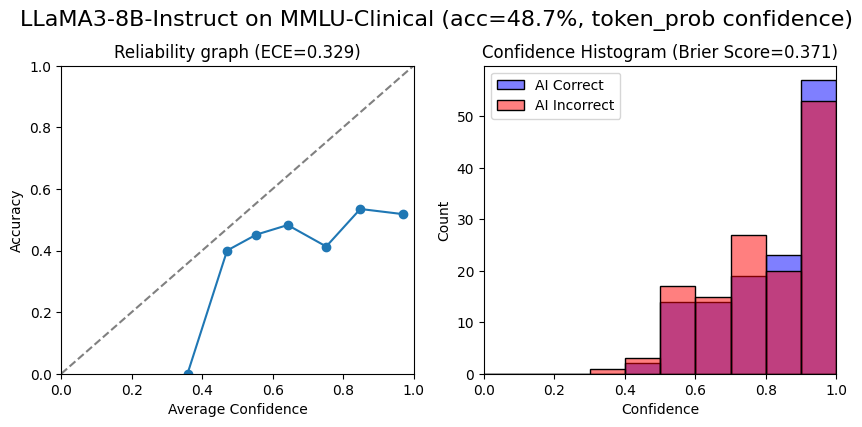

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f"{LLM_TO_DISPLAY_NAME[llm]} on {DATASET_TO_DISPLAY_NAME[dataset]} (acc={overall_acc:.1%}, {conf_measure} confidence)", fontsize=16, y=1.02)

ax1.plot(bin_confs, bin_accs, marker='o')
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xlabel('Average Confidence')
ax1.set_ylabel('Accuracy')
ax1.set_title(f'Reliability graph (ECE={ece:.3f})')

sns.histplot(confs_when_correct, bins=num_bins, ax=ax2, color='blue', alpha=0.5, binrange=(0, 1), label='AI Correct')
sns.histplot(confs_when_incorrect, bins=num_bins, ax=ax2, color='red', alpha=0.5, binrange=(0, 1), label='AI Incorrect')
ax2.set_xlabel('Confidence')
ax2.set_ylabel('Count')
ax2.set_xlim([0, 1])
ax2.set_title('Confidence Histogram (Brier Score={:.3f})'.format(brier_score))
ax2.legend()
